# Morris Sensitivity Analysis for d-HyMoLAP Model

**Strict Implementation According to:**
- Morris (1991): One-At-a-Time global screening method
- Campolongo et al. (2007): Trajectory optimization

**Model:** d-HyMoLAP (discrete, deterministic)

**Parameters:** 4 (μ, λ, Qs, qs)

**Catchments:** 20 independent analyses

**Metric:** NSE only

**Note:** Variables follow reference notebook naming convention:
- Effective rainfall: `q = max(0, P - PET)`
- CAMELS-FR variables: `q_cms_obs`, `pcp_mm`, `pet_mm_pm`

**Author:** Lionel Cedric Gohouede

---
## 1. Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import qmc
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Morris parameters
NUM_TRAJECTORIES = 10     # r trajectories
NUM_LEVELS = 4            # p levels (Morris recommends 4-6)
DELTA = 2 / (NUM_LEVELS - 1)  # Step size Δ = 2/(p-1)

print("✓ Libraries loaded")
print(f"  Morris parameters: r={NUM_TRAJECTORIES}, p={NUM_LEVELS}, Δ={DELTA:.3f}")

✓ Libraries loaded
  Morris parameters: r=10, p=4, Δ=0.667


---
## 2. Load Data

In [ ]:
# Install aqua-fetch if needed
try:
    from aqua_fetch import RainfallRunoff
except ImportError:
    !pip install aqua-fetch -q
    from aqua_fetch import RainfallRunoff

# Fetch CAMELS-FR
print("Fetching CAMELS-FR data...")
rr = RainfallRunoff("CAMELS_FR")
meta, ds = rr.fetch()

# Select time period (same as reference notebook)
ds_data = ds.sel(time=slice("2006-01-01", "2021-12-31"))

print(f"✓ Data loaded: {len(ds_data)} stations available")
print(f"  Period: 2006-01-01 to 2021-12-31")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.1/289.1 kB 5.8 MB/s eta 0:00:00
Fetching CAMELS-FR data...
downloading 6 files to /usr/local/lib/python3.12/dist-packages/aqua_fetch/data/CAMELS/CAMELS_FR
downloading ADDITIONAL_LICENSES.zip
0% of 0.07 MB downloaded
100% of 0.07 MB downloaded
downloading CAMELS_FR_attributes.zip
0% of 9.88 MB downloaded
100% of 9.88 MB downloaded
downloading CAMELS_FR_geography.zip
0% of 1.45 MB downloaded
100% of 1.45 MB downloaded
downloading CAMELS_FR_time_series.zip
0% of 361.39 MB downloaded
20% of 361.39 MB downloaded
40% of 361.39 MB downloaded
60% of 361.39 MB downloaded
80% of 361.39 MB downloaded
100% of 361.39 MB downloaded
downloading README.md
0% of 0.01 MB downloaded
100% of 0.01 MB downloaded
downloading CAMELS-FR_description.ods
0% of 0.05 MB downloaded
100% of 0.05 MB downloaded
unzipping files in /usr/local/lib/python3.12/dist-packages/aqua_fetch/data/CAMELS/CAMELS_FR
unzipping CAMELS_FR_attributes.zip to CAMELS_FR_attributes
unzipping C

In [ ]:
# Select 20 catchments (reproducible)
np.random.seed(RANDOM_SEED)
all_stations = list(ds_data.keys())
SELECTED_STATIONS = np.random.choice(all_stations, size=20, replace=False)

print(f"Selected 20 catchments:")
for i, station in enumerate(SELECTED_STATIONS, 1):
    print(f"  {i:2d}. {station}")

Selected 20 catchments:
   1. L574191001
   2. E550572001
   3. R202001001
   4. K259301001
   5. M350401010
   6. Y862000101
   7. B115001001
   8. D020601001
   9. H703301001
  10. B109201001
  11. J813301001
  12. F352000201
  13. O839431001
  14. H616201001
  15. B457201001
  16. Y781000101
  17. Y510661001
  18. G111041010
  19. K177301001
  20. I505301001


---
## 3. d-HyMoLAP Model

**Following reference notebook (CAMELS_FR_HyMoLAP_Dimensional_Consistent_use_same_day.ipynb):**

$$
\begin{align}
r_t &= q_t / q_s \quad \text{(normalized effective rainfall)} \\
k_0 &= Q_0 / Q_s \quad \text{(normalized initial condition)} \\
\\[-0.5em]
x_{t+1} &= \begin{cases}
x_t + \frac{\mu}{\lambda} r_{t+1} & \text{if } r_{t+1} > 0 \\
\left(1 - \frac{\mu}{\lambda}\right) x_t & \text{if } r_{t+1} = 0
\end{cases} \\
\\[-0.5em]
k_{t+1} &= \max\left(0, k_t - \frac{\mu}{\lambda} k_t^{2\mu-1} + \frac{1}{\lambda} x_{t+1} r_{t+1}\right) \\
\\[-0.5em]
Q_t &= k_t \cdot Q_s
\end{align}
$$

where $q = \max(0, P - PET)$ is effective rainfall (net input).

In [ ]:
def dHyMoLAP_Model(params, Q0, q):
    """
    d-HyMoLAP model (dimensional consistent version).

    Following reference notebook implementation.

    Parameters
    ----------
    params : array-like, shape (4,)
        [mu, lambda_, Qs, qs]
    Q0 : float
        Initial discharge [mm/day]
    q : ndarray, shape (n_timesteps,)
        Effective rainfall (P - PET) [mm/day]

    Returns
    -------
    Q : ndarray, shape (n_timesteps,)
        Simulated discharge [mm/day]
    """
    mu, lambda_, Qs, qs = params

    # Validation
    if Qs <= 0 or qs <= 0 or lambda_ <= 0 or mu <= 0:
        return np.full(len(q), np.nan)

    N = len(q)

    # Non-dimensionalize
    k_0 = Q0 / Qs
    r = q / qs  # Normalized effective rainfall

    # Initialize non-dimensional arrays
    k = np.zeros(N)
    x = np.zeros(N)

    k[0] = k_0
    x[0] = 0.0

    # Time stepping (following reference notebook logic)
    for t in range(N - 1):
        # Skip if missing data
        if np.isnan(r[t+1]):
            k[t+1] = k[t]
            x[t+1] = x[t]
            continue

        # Storage update
        if r[t+1] > 0:
            x[t+1] = x[t] + (mu / lambda_) * r[t+1]
        else:
            x[t+1] = (1 - mu / lambda_) * x[t]

        # Nonlinear recession + storage input
        recession = (mu / lambda_) * k[t]**(2*mu - 1)
        input_term = (1 / lambda_) * x[t+1] * r[t+1]

        k[t+1] = max(0.0, k[t] - recession + input_term)

    # Convert back to physical units
    Q = k * Qs

    return Q


def NSE(Q_obs, Q_sim):
    """
    Nash-Sutcliffe Efficiency.

    NSE = 1 - SS_res / SS_tot

    Returns
    -------
    float : NSE ∈ (-∞, 1]
    """
    # Remove NaNs
    valid = ~(np.isnan(Q_obs) | np.isnan(Q_sim))
    obs_clean = Q_obs[valid]
    sim_clean = Q_sim[valid]

    if len(obs_clean) == 0:
        return np.nan

    # Variance check
    if np.var(obs_clean) == 0:
        return np.nan

    # NSE formula
    numerator = np.sum((obs_clean - sim_clean)**2)
    denominator = np.sum((obs_clean - np.mean(obs_clean))**2)

    return 1.0 - numerator / denominator


print("✓ d-HyMoLAP model defined (dimensional consistent version)")

✓ d-HyMoLAP model defined (dimensional consistent version)


---
## 4. Morris Method Implementation

**Standard Morris (1991) OAT sampling:**

1. Define parameter bounds and grid
2. Generate r trajectories (each with M+1 points)
3. Compute Elementary Effects (EE) for each trajectory
4. Aggregate: μ*, σ

In [ ]:
# Parameter bounds (d-HyMoLAP - matching reference notebook)
PARAM_NAMES = ['mu', 'lambda', 'Qs', 'qs']
BOUNDS = np.array([
    [0.5, 2.5],    # mu (nonlinearity)
    [1.0, 200.0],   # lambda (timescale)
    [0.001, 10.0],  # Qs (discharge scaling)
    [0.001, 20.0]    # qs (rainfall efficiency)
])
M = len(PARAM_NAMES)

print(f"Parameters: {PARAM_NAMES}")
print(f"Bounds:")
for i, name in enumerate(PARAM_NAMES):
    print(f"  {name:8s}: [{BOUNDS[i,0]:6.2f}, {BOUNDS[i,1]:6.2f}]")

Parameters: ['mu', 'lambda', 'Qs', 'qs']
Bounds:
  mu      : [  0.50,   2.50]
  lambda  : [  1.00, 200.00]
  Qs      : [  0.00,  10.00]
  qs      : [  0.00,  20.00]


In [ ]:
def generate_morris_trajectory(M, p, bounds):
    """
    Generate a single Morris trajectory (M+1 points).

    Following Campolongo et al. (2007) optimal design:
    - Start from random grid point
    - Perturb one parameter at a time by Δ
    - Random perturbation direction

    Parameters
    ----------
    M : int
        Number of parameters
    p : int
        Number of grid levels
    bounds : ndarray, shape (M, 2)
        Parameter bounds

    Returns
    -------
    trajectory : ndarray, shape (M+1, M)
        Morris trajectory in normalized [0,1] space
    """
    Delta = 2.0 / (p - 1)
    grid_values = np.linspace(0, 1 - Delta, p - 1)
    x_start = np.random.choice(grid_values, size=M)

    # Initialize trajectory
    trajectory = np.zeros((M + 1, M))
    trajectory[0, :] = x_start

    # Random parameter order
    param_order = np.random.permutation(M)

    # Build trajectory (OAT perturbations)
    for i, param_idx in enumerate(param_order):
        trajectory[i+1, :] = trajectory[i, :].copy()

        # Current value
        current_val = trajectory[i, param_idx]

        # Random direction (+Δ or -Δ)
        direction = np.random.choice([-1, 1])
        new_val = current_val + direction * Delta

        # Round to nearest grid point
        new_val = grid_values[np.argmin(np.abs(grid_values - new_val))]

        trajectory[i+1, param_idx] = new_val

    return trajectory


def scale_to_bounds(X_norm, bounds):
    """
    Scale normalized [0,1] to physical bounds.
    """
    X_phys = bounds[:, 0] + X_norm * (bounds[:, 1] - bounds[:, 0])
    return X_phys


print("✓ Morris trajectory generator defined")

✓ Morris trajectory generator defined


In [ ]:
def compute_elementary_effects(trajectory_norm, bounds, model_func):
    """
    Compute Elementary Effects for one trajectory.

    EE_i = [f(x + Δe_i) - f(x)] / Δ

    Parameters
    ----------
    trajectory_norm : ndarray, shape (M+1, M)
        Trajectory in [0,1] space
    bounds : ndarray, shape (M, 2)
        Parameter bounds
    model_func : callable
        Function that takes params and returns NSE

    Returns
    -------
    EE : ndarray, shape (M,)
        Elementary effects for each parameter
    """
    M = trajectory_norm.shape[1]
    Delta = 2.0 / (NUM_LEVELS - 1)

    EE = np.zeros(M)

    # Evaluate model at each point
    nse_values = np.zeros(M + 1)
    for i in range(M + 1):
        params_phys = scale_to_bounds(trajectory_norm[i, :], bounds)
        nse_values[i] = model_func(params_phys)

    # Compute EE for each parameter
    for i in range(M):
        # Find which parameter changed between step i and i+1
        diff = trajectory_norm[i+1, :] - trajectory_norm[i, :]
        param_idx = np.argmax(np.abs(diff))

        # Elementary effect
        delta_nse = nse_values[i+1] - nse_values[i]
        delta_param = diff[param_idx]

        if np.abs(delta_param) > 1e-10:
            EE[param_idx] = delta_nse / Delta
        else:
            EE[param_idx] = 0.0

    return EE


print("✓ Elementary effects function defined")

✓ Elementary effects function defined


In [ ]:
def morris_sensitivity(bounds, model_func, num_trajectories, p):
    """
    Perform Morris sensitivity analysis.

    Parameters
    ----------
    bounds : ndarray, shape (M, 2)
        Parameter bounds
    model_func : callable
        Function: params → NSE
    num_trajectories : int
        Number of trajectories (r)
    p : int
        Number of grid levels

    Returns
    -------
    results : dict
        'mu_star': Modified mean (importance)
        'sigma_EE': Standard deviation (nonlinearity/interactions)
        'EE_all': All elementary effects, shape (r, M)
    """
    M = bounds.shape[0]
    EE_all = np.zeros((num_trajectories, M))

    print(f"  Generating {num_trajectories} trajectories...")

    for r in range(num_trajectories):
        # Generate trajectory
        traj = generate_morris_trajectory(M, p, bounds)

        # Compute EE
        EE = compute_elementary_effects(traj, bounds, model_func)
        EE_all[r, :] = EE

        if (r + 1) % 5 == 0:
            print(f"    Trajectory {r+1}/{num_trajectories} complete")

    # Morris statistics
    mu_star = np.nanmean(np.abs(EE_all), axis=0)
    sigma_EE = np.nanstd(EE_all, axis=0)

    results = {
        'mu_star': mu_star,
        'sigma_EE': sigma_EE,
        'EE_all': EE_all
    }

    return results


print("✓ Morris sensitivity function defined")

✓ Morris sensitivity function defined


---
## 5. Run Morris Analysis for 20 Catchments

In [ ]:
# Storage for all results
all_results = {}

print("="*80)
print("MORRIS SENSITIVITY ANALYSIS - 20 CATCHMENTS")
print("="*80)

for i, station_id in enumerate(SELECTED_STATIONS, 1):
    print(f"\n[{i:2d}/20] Station: {station_id}")

    # Extract data (correct CAMELS-FR variable names)
    Q_obs = 1/1000 * ds_data[station_id].sel(dynamic_features="q_cms_obs").to_numpy()  # convert into m^3/s
    P = ds_data[station_id].sel(dynamic_features="pcp_mm").to_numpy()
    PET = ds_data[station_id].sel(dynamic_features="pet_mm_pm").to_numpy()

    # Effective rainfall (following reference notebook)
    q = np.maximum(0, P - PET)

    # Initial condition
    Q0 = np.nanmean(Q_obs[:30])  # Mean of first month
    if np.isnan(Q0) or Q0 <= 0:
        Q0 = 1.0

    # Define model function for this catchment
    def model_objective(params):
          Q_sim = dHyMoLAP_Model(params, Q0, q)
          nse = NSE(Q_obs, Q_sim)

          if not np.isfinite(nse):
              return np.nan

          nse = np.clip(nse, -1.0, 1.0)
          return 1.0 / (2.0 - nse)  # bounded NNSE

    # Run Morris analysis
    results = morris_sensitivity(
        bounds=BOUNDS,
        model_func=model_objective,
        num_trajectories=NUM_TRAJECTORIES,
        p=NUM_LEVELS
    )

    # Store results
    all_results[station_id] = results

    # Quick summary
    print(f"  Results:")
    for j, param in enumerate(PARAM_NAMES):
        print(f"    {param:8s}: μ* = {results['mu_star'][j]:.4f}, σ = {results['sigma_EE'][j]:.4f}")

print(f"\n{'='*80}")
print("✓ Morris analysis complete for all 20 catchments")
print(f"{'='*80}")

MORRIS SENSITIVITY ANALYSIS - 20 CATCHMENTS

[ 1/20] Station: L574191001
  Generating 10 trajectories...
    Trajectory 5/10 complete
    Trajectory 10/10 complete
  Results:
    mu      : μ* = 0.0030, σ = 0.0089
    lambda  : μ* = 0.0222, σ = 0.0516
    Qs      : μ* = 0.0531, σ = 0.0892
    qs      : μ* = 0.1488, σ = 0.1715

[ 2/20] Station: E550572001
  Generating 10 trajectories...
    Trajectory 5/10 complete
    Trajectory 10/10 complete
  Results:
    mu      : μ* = 0.0000, σ = 0.0000
    lambda  : μ* = 0.0000, σ = 0.0000
    Qs      : μ* = 0.0008, σ = 0.0025
    qs      : μ* = 0.0000, σ = 0.0000

[ 3/20] Station: R202001001
  Generating 10 trajectories...
    Trajectory 5/10 complete
    Trajectory 10/10 complete
  Results:
    mu      : μ* = 0.0394, σ = 0.0706
    lambda  : μ* = 0.0127, σ = 0.0251
    Qs      : μ* = 0.0395, σ = 0.0750
    qs      : μ* = 0.0584, σ = 0.0916

[ 4/20] Station: K259301001
  Generating 10 trajectories...
    Trajectory 5/10 complete
    Trajectory 10

---
## 6. Aggregate Results Across Catchments

In [ ]:
# Extract all mu_star and sigma_EE values
mu_star_all = np.array([all_results[s]['mu_star'] for s in SELECTED_STATIONS])
sigma_EE_all = np.array([all_results[s]['sigma_EE'] for s in SELECTED_STATIONS])

# Shape: (20 catchments, 4 parameters)
print(f"mu_star_all shape: {mu_star_all.shape}")
print(f"sigma_EE_all shape: {sigma_EE_all.shape}")

# Compute catchment-averaged sensitivities
mu_star_avg = np.mean(mu_star_all, axis=0)
mu_star_std = np.std(mu_star_all, axis=0)

sigma_EE_avg = np.mean(sigma_EE_all, axis=0)
sigma_EE_std = np.std(sigma_EE_all, axis=0)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Parameter': PARAM_NAMES,
    'mu_star_mean': mu_star_avg,
    'mu_star_std': mu_star_std,
    'sigma_EE_mean': sigma_EE_avg,
    'sigma_EE_std': sigma_EE_std
})

# Sort by importance
summary_df = summary_df.sort_values('mu_star_mean', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("AVERAGED SENSITIVITY INDICES (20 CATCHMENTS)")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

mu_star_all shape: (20, 4)
sigma_EE_all shape: (20, 4)

AVERAGED SENSITIVITY INDICES (20 CATCHMENTS)
Parameter  mu_star_mean  mu_star_std  sigma_EE_mean  sigma_EE_std
       qs      0.072389     0.043952       0.102088      0.050299
       Qs      0.039376     0.027300       0.071412      0.042868
   lambda      0.031239     0.024990       0.059426      0.039945
       mu      0.016576     0.017052       0.037465      0.036306


---
## 7. Visualization

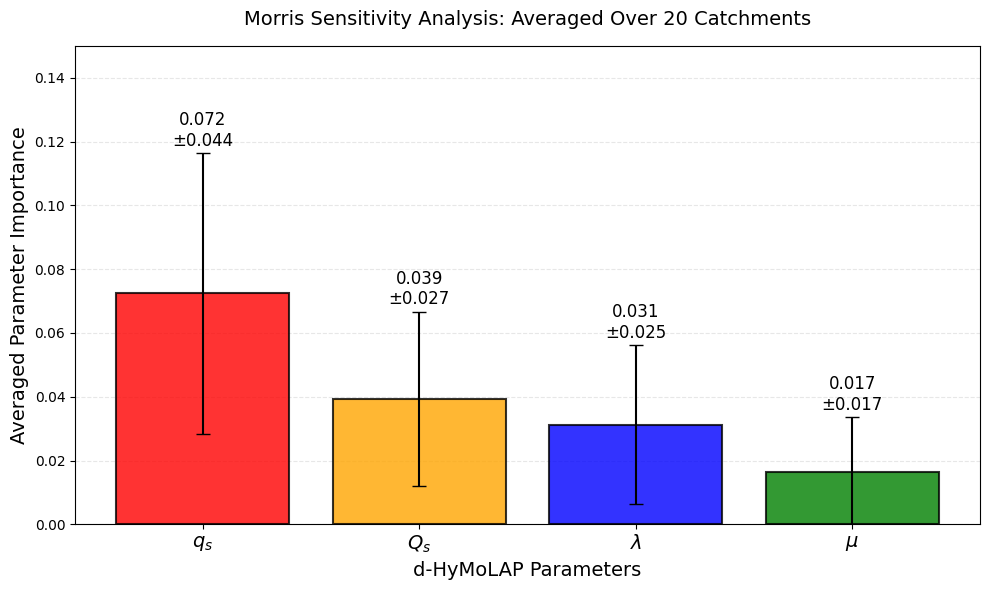

✓ Averaged sensitivity plot saved


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the mapping for symbols
PARAM_SYMBOLS = {
    'mu': r'$\mu$',
    'lambda': r'$\lambda$',
    'Qs': r'$Q_s$',
    'qs': r'$q_s$'
}

# Publication-ready bar plot
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(PARAM_NAMES))
sorted_idx = np.argsort(mu_star_avg)[::-1]

# Map original names to symbols for the x-axis
sorted_params_raw = [PARAM_NAMES[i] for i in sorted_idx]
sorted_symbols = [PARAM_SYMBOLS.get(p, p) for p in sorted_params_raw]

sorted_mu = mu_star_avg[sorted_idx]
sorted_std = mu_star_std[sorted_idx]

# Bar plot with error bars
bars = ax.bar(x_pos, sorted_mu, yerr=sorted_std,
              capsize=5, alpha=0.8, edgecolor='black', linewidth=1.5,
              color=['red', 'orange', 'blue', 'green'][:len(sorted_symbols)])

# Labels
ax.set_xlabel('d-HyMoLAP Parameters', fontsize=14)
ax.set_ylabel(r'Averaged Parameter Importance', fontsize=14)
ax.set_title('Morris Sensitivity Analysis: Averaged Over 20 Catchments',
              fontsize=14, pad=15)
# Fix axis dimensions
ax.set_ylim(0, 0.15)

# X-axis - Symbols applied here
ax.set_xticks(x_pos)
ax.set_xticklabels(sorted_symbols, fontsize=14)

# Grid
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_axisbelow(True)

# Add value labels on bars
for i, (bar, val, std) in enumerate(zip(bars, sorted_mu, sorted_std)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.001,
            f'{val:.3f}\n±{std:.3f}',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('Morris_Sensitivity_Averaged.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Averaged sensitivity plot saved")

---
## 8. Per-Catchment Results Table

In [ ]:
# Create detailed results table
detailed_results = []

for station in SELECTED_STATIONS:
    mu_star = all_results[station]['mu_star']
    sigma_EE = all_results[station]['sigma_EE']

    for i, param in enumerate(PARAM_NAMES):
        detailed_results.append({
            'Station': station,
            'Parameter': param,
            'mu_star': float(mu_star[i]),  # Explicit conversion to float
            'sigma_EE': float(sigma_EE[i])  # Explicit conversion to float
        })

detailed_df = pd.DataFrame(detailed_results)

# Ensure proper data types
detailed_df['mu_star'] = detailed_df['mu_star'].astype(float)
detailed_df['sigma_EE'] = detailed_df['sigma_EE'].astype(float)

# Save to CSV (with explicit path)
try:
    detailed_df.to_csv('Morris_Results_20_Catchments.csv', index=False, float_format='%.6f')
    print("✓ Detailed results saved to Morris_Results_20_Catchments.csv")
except Exception as e:
    print(f"⚠️ CSV save failed: {e}")
    print("Attempting alternative save method...")
    # Alternative: write manually
    with open('Morris_Results_20_Catchments.csv', 'w') as f:
        f.write('Station,Parameter,mu_star,sigma_EE\n')
        for _, row in detailed_df.iterrows():
            f.write(f"{row['Station']},{row['Parameter']},{row['mu_star']:.6f},{row['sigma_EE']:.6f}\n")
    print("✓ Results saved using alternative method")

print(f"\nFirst 20 rows:")
print(detailed_df.head(20).to_string())

✓ Detailed results saved to Morris_Results_20_Catchments.csv

First 20 rows:
       Station Parameter   mu_star  sigma_EE
0   L574191001        mu  0.002953  0.008859
1   L574191001    lambda  0.022239  0.051568
2   L574191001        Qs  0.053147  0.089185
3   L574191001        qs  0.148826  0.171460
4   E550572001        mu  0.000000  0.000000
5   E550572001    lambda  0.000000  0.000000
6   E550572001        Qs  0.000845  0.002534
7   E550572001        qs  0.000000  0.000000
8   R202001001        mu  0.039408  0.070555
9   R202001001    lambda  0.012688  0.025098
10  R202001001        Qs  0.039514  0.074964
11  R202001001        qs  0.058365  0.091593
12  K259301001        mu  0.000000  0.000000
13  K259301001    lambda  0.010587  0.029258
14  K259301001        Qs  0.019021  0.047709
15  K259301001        qs  0.007302  0.021865
16  M350401010        mu  0.000000  0.000000
17  M350401010    lambda  0.041370  0.082766
18  M350401010        Qs  0.007460  0.014921
19  M350401010        q